# Final Project Report

Project title: Implementing NN, RNN, and LSTM to analyze data set for the setup assembly line balancing problem  
Prepared by: Ai Song Thu Dinh

### Main objective

The objective of this project is to implement three variations of the Deep Learning model to analyze a data set for the setup assembly line balancing problem. Three variations were chosen, including the basic neural network (NN), recurrent neural network (RNN) and long-short-term memory (LSTM). All three models aim to predict task times based on the chosen data set, using mainly task times and precedence relations. This analysis will benefit research in assembly line balancing and scheduling problems. On a side note, this project helps author expand her knowledge and gain experience in her research.

### Data set description and attributes

The chosen data set is SBF1, generated by Scholl et al. (2013) for the setup assembly line balancing and scheduling problem.  
Link: https://assembly-line-balancing.de/sualbsp/data-set-of-scholl-et-al-2013/  
  
This data set consists of 4 folders (SBF1-1.00, SBF1-0.75, SBF1-0.50, SBF1-0.25) and each folder has 269 .alb files that stores data.  
In each file, all the data are in one column.5
</details>  

<details>
<summary>Click to view sample data</summary>
  
`<cycle time>`  
10027  
  
`<number of tasks>`  
111  
  
`<task times>`  
1 1960  
2 1715  
3 735  
...  
110 162  
111 91  
  
`<precedence relations>`  
1,2  
2,3  
3,4  
...  
109,111    
110,111  
  
`<setup times forward>`  
1,2:137  
2,3:190  
3,4:100  
...  
110,109:74  
110,111:20  
  
`<setup times backward>`  
1,1:336  
2,1:473  
2,2:336  
...  
111,110:356  
111,111:336
</details>  

`<cycle time>` refers to the time it takes to complete a single production cycle. This data is unique and singular.  
  
`<number of tasks>` refers to the total number of tasks to process a product within one cycle.  
  
`<task times>` For example, 1 1960 indicates the time it takes to perform task 1 is 1960.  
  
`<precedence relations>` For example, 1,2 indicates task 1 must be completed before task 2 can begin.  

`<setup times forward>` For exammple, 1,2:137 indicates the time it takes to transfer from task 1 to task 2 within one cycle is 137.  
  
`<setup times backward>` For exammple, 1,1:33 indicates the time it takes to transfer from task 1 in one cycle to task 1 in the next cycle is 33.  
  
Only task times and precedence relations data are used in this analysis. Since the tasks are performed according to their precedence relations, both task times and precedence relations are considered **sequential data**. Precedence relations define the order in which each task must be performed, and task times provide the duration for each task.

The purposes of choosing this data set for analysis are:
- To explore and preprocess sequential data for the setup assembly line balancing and scheduling problem
- To split the sequential data into a **train set** (`X_train`) and a **test set** (`X_test`)
- To structure and train the NN, RNN and LSTM and make predictions for the test set
- To compare training loss and model performance and conclude the most suitable model for the chosen data set

### Data exploration and preprocessing

The first step is to install all the necessary libraries

In [10]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

Next, the function `read_alb_file` load the data set into a list of dictionaries named `all_data`

In [11]:
# Define the path to the data folders
base_path = os.path.expanduser(r'~\Downloads\DataSet SBF1')
data_folders = ['SBF1-0.25', 'SBF1-0.50', 'SBF1-0.75', 'SBF1-1.00']

# Function to read and load .ALB files
def read_alb_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    data = {}
    current_header = None
    
    for line in lines:
        line = line.strip()
        if line.startswith('<') and line.endswith('>'):
            current_header = line[1:-1]
            data[current_header] = []
        elif current_header:
            data[current_header].append(line)
    
    # Convert lists to appropriate data structures
    for key, value in data.items():
        if key in ['number of tasks', 'cycle time']:
            if value:
                data[key] = int(value[0].split('(')[0])
            else:
                data[key] = None
        elif key == 'task times':
            data[key] = {int(k.split()[0]): int(k.split()[1]) for k in value if ' ' in k}
        elif key in ['precedence relations']:
            data[key] = [tuple(map(int, k.split(','))) for k in value if ',' in k]
        elif key == 'setup times forward':
            data[key] = {tuple(map(int, k.split(':')[0].split(','))): int(k.split(':')[1]) for k in value if ':' in k}
        elif key == 'setup times backward':
            data[key] = {tuple(map(int, k.split(':')[0].split(','))): int(k.split(':')[1]) for k in value if ':' in k}
    
    return data

# Load all .ALB files into a list of dictionaries
all_data = []
for folder in data_folders:
    folder_path = os.path.join(base_path, folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.alb'):
            file_path = os.path.join(folder_path, file_name)
            data = read_alb_file(file_path)
            all_data.append(data)

Next, the function `preprocess_data_with_precedence` preprocesses the created list `all_data` and performs the following steps:
- Extract task times and precedence relations
- Create a dictionary named `task_sequence` to store task times and their precedence relations
- Generate sequences of task times based on precedence relations
- Pad the sequences to ensure they have the same length and return the padded sequences and labels
- Split the data into training and testing sets (`X_train`, `X_test`, `y_train`, `y_test`)
- Normalize the labels  

In [13]:
# Function to preprocess data
def preprocess_data_with_precedence(all_data):
    sequences = []
    labels = []

    for data in all_data:
        task_times = data['task times']
        precedence_relations = data['precedence relations']
        
        # Create a dictionary to store the sequence of tasks
        task_sequence = {}
        for task, time in task_times.items():
            task_sequence[task] = {'time': time, 'precedence': []}
        
        # Add precedence relations to the task sequence
        for before, after in precedence_relations:
            task_sequence[after]['precedence'].append(before)
        
        # Generate sequences based on precedence relations
        for task, info in task_sequence.items():
            sequence = [task_sequence[prec]['time'] for prec in info['precedence']]
            sequences.append(sequence)
            labels.append(info['time'])
    
    # Pad sequences to have the same length
    max_length = max(len(seq) for seq in sequences)
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post')
    
    return np.array(sequences), np.array(labels)

# Preprocess the data
sequences, labels = preprocess_data_with_precedence(all_data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Normalize the labels
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))

### Summary of training variations of Deep Learning models

In this section, three variations of the Deep Learning model are chosen to analyze data:
1. Basic neural network (NN)
2. Recurrent neural network (RNN)
3. Long-Short Term Memory (LSTM) network  
  
The model architecture is defined and trained. The model is trained to predict a target variable (`y_train`) from the input sequences (`X_train`). After training, the model makes predictions on the test set (`X_test`), and these predictions are continuous values.  
  
Hyperparameters:
- The NN model uses `Dense` layers
- The RNN model uses `SimpleRNN` layers
- The LSTM model uses `LSTM` layers with `Dropout` for regularization, and `EarlyStopping` technique to prevent overfitting.  
  
These hyperparameters affect the model’s ability to capture dependencies in the data.

#### Basic Neural Network (NN)

For structuring and designing the NN, this function is used to:
- Define the NN model with Input layer (to prevent the reminder from `Keras`)
- Train the model and store history
- Plot the training and validation loss

Epoch 1/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 67.7539 - val_loss: 0.0108
Epoch 2/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.8379 - val_loss: 0.0105
Epoch 3/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0194 - val_loss: 0.0331
Epoch 4/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.5782 - val_loss: 0.0426
Epoch 5/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1289 - val_loss: 0.0138
Epoch 6/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0971 - val_loss: 0.0111
Epoch 7/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0898 - val_loss: 0.0104
Epoch 8/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0720 - val_loss: 0.0103
Epoch 9/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0595 - val_loss: 0.0105
Epoch 10/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0166 - val_loss: 0.0689
Epoch 11/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0347 - val_loss: 0.0103
Epoch 12/50
2550/2550 ━━━━

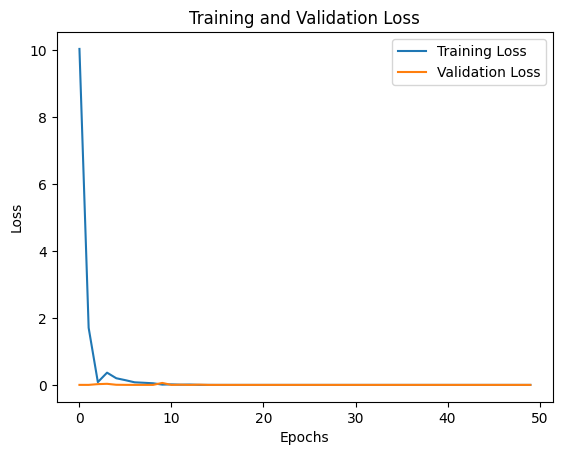

638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[[[0.24901089]
  [0.16787927]
  [0.03730363]
  ...
  [0.03730363]
  [0.03730363]
  [0.03730363]]

 [[0.0054184 ]
  [0.03730363]
  [0.03730363]
  ...
  [0.03730363]
  [0.03730363]
  [0.03730363]]

 [[0.02325707]
  [0.04646727]
  [0.03730363]
  ...
  [0.03730363]
  [0.03730363]
  [0.03730363]]

 ...

 [[0.00238663]
  [0.03730363]
  [0.03730363]
  ...
  [0.03730363]
  [0.03730363]
  [0.03730363]]

 [[0.13056974]
  [0.03730363]
  [0.03730363]
  ...
  [0.03730363]
  [0.03730363]
  [0.03730363]]

 [[0.02863067]
  [0.03730363]
  [0.03730363]
  ...
  [0.03730363]
  [0.03730363]
  [0.03730363]]]


In [14]:
# Define and compile the NN model
model_nn = Sequential()
model_nn.add(Input(shape=(sequences.shape[1], 1)))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(1))
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Train the model, store history and show loss
history = model_nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
loss = model_nn.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Make predictions
nn_predictions = model_nn.predict(X_test)
print(nn_predictions)

#### Recurrent Neural Network (RNN)

For structuring and designing the RNN, this function is used to:
- Reshape `X_train`, `X_test` for the RNN
- Define the RNN model with Input layer
- Train the model and store history
- Plot the training and validation loss

Epoch 1/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.7542 - val_loss: 0.0995
Epoch 2/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.4138 - val_loss: 0.0058
Epoch 3/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0055 - val_loss: 0.3465
Epoch 4/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0397 - val_loss: 0.0054
Epoch 5/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 6/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 7/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 8/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 9/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 10/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0049 - val_loss: 0.0065
Epoch 11/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 12/50
2550/25

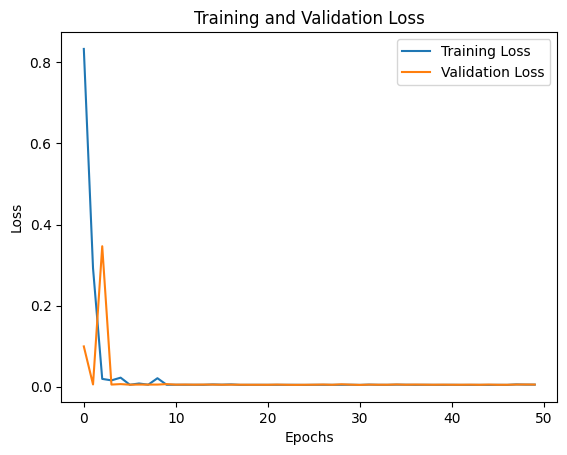

638/638 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
[[0.22347298]
 [0.01370004]
 [0.06050915]
 ...
 [0.01385391]
 [0.09464402]
 [0.01580924]]


In [15]:
# Reshape the data for the RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define and compile the RNN model
model_rnn = Sequential()
model_rnn.add(Input(shape=(sequences.shape[1], 1)))
model_rnn.add(SimpleRNN(64, activation='relu'))
model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mean_squared_error')

# Train the model, store history and show loss
history = model_rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
loss = model_rnn.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Make predictions
rnn_predictions = model_rnn.predict(X_test)
print(rnn_predictions)

#### Long-Short-Term Memory (LSTM)

For structuring and designing the LSTM, this function is used to:
- Reshape `X_train` and `X_test` for the LSTM
- Define the LSTM model with Input layer
- Train the model and store history
- Plot the training and validation loss  
  
The `EarlyStopping` technique is used to stop the training process if the model’s performance on a validation set stops improving.

Epoch 1/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - loss: 0.0135 - val_loss: 0.0076
Epoch 2/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 3/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 83s 18ms/step - loss: 0.0069 - val_loss: 0.0078
Epoch 4/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 5/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 6/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 7/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 83s 18ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 8/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 9/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 10/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 11/50
2550/2550 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 12

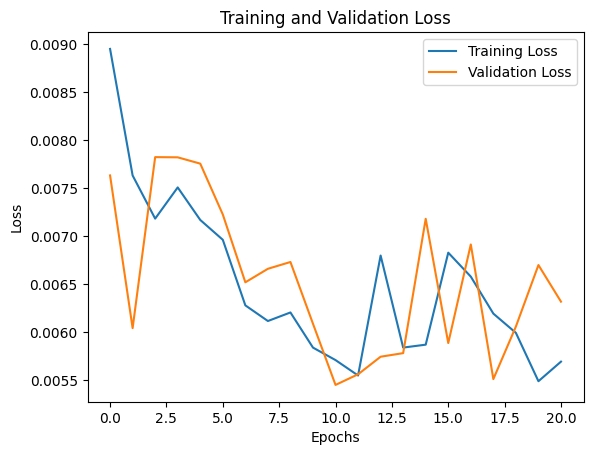

638/638 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
[[0.26277182]
 [0.00406949]
 [0.008556  ]
 ...
 [0.0044078 ]
 [0.12090693]
 [0.01049853]]


In [16]:
# Reshape the data for the LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model with Input layer
model_lstm = Sequential()
model_lstm.add(Input(shape=(sequences.shape[1], 1)))
model_lstm.add(LSTM(50, activation='tanh', return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, activation='tanh'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model, store history and show loss
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
loss = model_lstm.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Make predictions
lstm_predictions = model_lstm.predict(X_test)
print(lstm_predictions)

### Model comparison and recommendation

#### Training Loss

Among the three models, the RNN and LSTM models show lower loss values compared to the NN model, indicating better performance in capturing sequential dependencies in the data. The LSTM model, with its ability to handle long-term dependencies, is the most suitable for analyzing the given dataset and is particularly effective for assembly line balancing and job scheduling tasks due to its advanced memory capabilities.

#### Model performance

Since this is a regression task, this function is used to compute performance metrics: MAE, MSE, RMSE, R-squared

In [31]:
# Function to evaluate model performance for regression
def evaluate_regression_model(y_true, y_pred):
    y_pred = y_pred.flatten()[:len(y_true)]  # Flatten the predictions and ensure the length matches y_true
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    return mae, mse, rmse, r2

# Evaluate NN model
nn_mae, nn_mse, nn_rmse, nn_r2 = evaluate_regression_model(y_test, nn_predictions)
print(f'NN Model - MAE: {nn_mae}, MSE: {nn_mse}, RMSE: {nn_rmse}, R²: {nn_r2}')

# Evaluate RNN model
rnn_mae, rnn_mse, rnn_rmse, rnn_r2 = evaluate_regression_model(y_test, rnn_predictions)
print(f'RNN Model - MAE: {rnn_mae}, MSE: {rnn_mse}, RMSE: {rnn_rmse}, R²: {rnn_r2}')

# Evaluate LSTM model
lstm_mae, lstm_mse, lstm_rmse, lstm_r2 = evaluate_regression_model(y_test, lstm_predictions)
print(f'LSTM Model - MAE: {lstm_mae}, MSE: {lstm_mse}, RMSE: {lstm_rmse}, R²: {lstm_r2}')

NN Model - MAE: 0.049540662721440976, MSE: 0.010972134445650842, RMSE: 0.10474795676122205, R²: -0.041125966594010466
RNN Model - MAE: 0.03216117737526427, MSE: 0.00542440017346374, RMSE: 0.07365052731286953, R²: 0.4852884913355472
LSTM Model - MAE: 0.028500459822974857, MSE: 0.005448734682097065, RMSE: 0.07381554498950113, R²: 0.4829794338820539


- The NN model has the highest MAE and MSE among the three models, indicating less accurate predictions. The RMSE is also the highest, suggesting larger errors in the predictions. The R² value is negative, which indicates that the model performs worse than a simple mean-based model.
- The RNN model shows a significant improvement over the NN model. It has lower MAE, MSE, and RMSE values, indicating more accurate predictions. The R² value is positive and relatively high, suggesting that the model explains a good portion of the variance in the data.
- The LSTM model has the lowest MAE, indicating the smallest average error in predictions. The MSE and RMSE are almost identical to the RNN model, showing similar performance in terms of error magnitude. The R² value is slightly lower than the RNN model but still indicates a good fit.

#### Recommendation

In summary, the analysis demonstrated that the **LSTM model is the most suitable for predicting task times in this dataset**, particularly for applications involving sequential dependencies like assembly line balancing and job scheduling. The RNN model also performed well, but the LSTM model’s ability to handle long-term dependencies made it more favorable.

### Key findings and insights

- **Objective:** The purpose of training the models is to predict task times based on the given dataset, which includes task times and precedence relations.
- **Model architecture:** The hyperparameters for each model significantly impact the model's performance. The NN model, with simple `Dense` layers, was less effective for this sequential data. The RNN and LSTM models, with their recurrent layers, were better suited for capturing the dependencies in the data. Both the RNN and LSTM models outperformed the NN model, highlighting the importance of considering sequential dependencies in the data. In the LSTM model, `EarlyStopping` is used to prevent overfitting.
- **Training loss:** The training loss indicates how well the model is learning to predict the target values; lower loss values suggest better performance. Among the three models, the RNN and LSTM models show lower loss values compared to the NN model.
- **Model performance:** The LSTM model has the lowest MAE, indicating the smallest average error in predictions. Overall, the LSTM model is performing slightly better in terms of prediction accuracy (MAE), while both models have similar error magnitudes (MSE and RMSE).
- **Model recommendation:** The analysis demonstrated that the LSTM model is the most suitable for predicting task times in this data set.

### Suggestion for next step

- Implement Reinforcement Learning (RL) algorithms like Q-learning
- Extend the code to a Deep Q-learning (DQN) model to optimize assembly line reconfiguration

### References

IBM. (n.d.). *Deep Learning and Reinforcement Learning Course Material: Modules 1, 2, 3, and 6.* Retrieved from Coursera  
https://www.coursera.org/learn/deep-learning-reinforcement-learning/  

Scholl, A., Boysen, N., & Fliedner, M. (2013). *Data Set for Assembly Line Balancing*. Retrieved from https://assembly-line-balancing.de/